In [1]:
import numpy as np, pandas as pd

INPUT = "ATUS_2010_PM_Masters_SouthMidwest_AllDays.csv"
df = pd.read_csv(INPUT, dtype={"case_id": str}, encoding="latin1")

# clean strings
for c in ["case_id","activity_name","start_time","stop_time","event_n"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

def hms_to_min(s):
    td = pd.to_timedelta(s)
    return (td.dt.total_seconds()/60).astype(int) % (24*60)

def split_cross_midnight(g):
    s = hms_to_min(g["start_time"])
    e = hms_to_min(g["stop_time"])
    g = g.assign(s=s.values, e=e.values)
    segs = []
    for _, r in g.iterrows():
        if r.e >= r.s:
            segs.append((int(r.s), int(r.e), str(r["activity_name"])))
        else:
            segs.append((int(r.s), 1440, str(r["activity_name"])))
            segs.append((0, int(r.e), str(r["activity_name"])))
    return segs

def has_overlap(segs):
    # minute-level counter
    counts = np.zeros(1440, dtype=np.int16)
    for s,e,_ in segs:
        counts[s:e] += 1
    return (counts >= 2).any()

# auto-pick first case with overlap
cid_pick = None
for cid, g in df.groupby("case_id", sort=False):
    segs = split_cross_midnight(g.sort_values(["start_time","stop_time","event_n"]))
    if segs and has_overlap(segs):
        cid_pick = cid
        break

print("Selected case with overlap:", cid_pick)
case_df = df[df["case_id"] == cid_pick].sort_values(["start_time","stop_time","event_n"])
display(case_df[["case_id","event_n","activity_name","start_time","stop_time"]].head(20))

# If you want to force a specific case, uncomment and set:
# cid_pick = "20100101100520"
# case_df = df[df["case_id"] == cid_pick].sort_values(["start_time","stop_time","event_n"])


Selected case with overlap: '20100101100520


,case_id,event_n,activity_name,start_time,stop_time
0,'20100101100520,1,Sleeping,04:00:00,07:00:00
1,'20100101100520,2,Eating and drinking,07:00:00,09:00:00
2,'20100101100520,3,Travel related to personal care,09:00:00,09:15:00
3,'20100101100520,4,Doing aerobics,09:15:00,10:15:00
4,'20100101100520,5,Travel related to personal care,10:15:00,10:25:00
5,'20100101100520,6,Security procedures rel. to consumer purchases,10:25:00,10:55:00
6,'20100101100520,7,Travel related to personal care,10:55:00,11:05:00
7,'20100101100520,8,Interior cleaning,11:05:00,11:15:00
8,'20100101100520,9,Sleeping,11:15:00,11:45:00
9,'20100101100520,10,Interior cleaning,11:45:00,12:15:00


In [2]:
import numpy as np, pandas as pd

# Reuse case_df and split_cross_midnight from earlier
segs = split_cross_midnight(case_df)

# Minute-level active counts
counts = np.zeros(1440, dtype=np.int16)
for s,e,_ in segs:
    counts[s:e] += 1

print("Max concurrent activities in this case:", counts.max())
print("Overlap minutes (>=2 active):", int((counts >= 2).sum()))
print("Active minutes (>0):", int((counts > 0).sum()))

# Show normalized segments
norm_tbl = pd.DataFrame(segs, columns=["seg_start","seg_stop","activity_name"]).sort_values(["seg_start","seg_stop"])
display(norm_tbl.head(20))


Max concurrent activities in this case: 2
Overlap minutes (>=2 active): 90
Active minutes (>0): 1440


,seg_start,seg_stop,activity_name
18,0,330,Sleeping
0,240,420,Sleeping
1,420,540,Eating and drinking
2,540,555,Travel related to personal care
3,555,615,Doing aerobics
4,615,625,Travel related to personal care
5,625,655,Security procedures rel. to consumer purchases
6,655,665,Travel related to personal care
7,665,675,Interior cleaning
8,675,705,Sleeping


In [3]:
import numpy as np, pandas as pd

# Minute-level active counts (true concurrency)
counts = np.zeros(1440, dtype=np.int16)
for s,e,_ in segs:
    counts[s:e] += 1

active_minutes  = int((counts > 0).sum())
overlap_minutes = int((counts >= 2).sum())
CI = (counts.sum() - active_minutes) / active_minutes if active_minutes else 0.0  # Concurrency Index

print(f"[PM — true intervals] active={active_minutes} min | overlap={overlap_minutes} min | CI={CI:.3f}")

# First-write-wins minute timeline to get non-overlapping minutes per activity
timeline = np.full(1440, "", dtype=object)
for s,e,name in sorted(segs, key=lambda x: (x[0], x[1])):
    blank = (timeline[s:e] == "")
    if blank.any():
        idx = np.where(blank)[0] + s
        timeline[idx] = name

pm_minutes_exact = pd.Series(timeline[timeline!=""]).value_counts().sort_values(ascending=False)
pm_hours_exact = (pm_minutes_exact/60).round(2)
display(pm_hours_exact.to_frame("PM_exact_hours"))


[PM — true intervals] active=1440 min | overlap=90 min | CI=0.062


,PM_exact_hours
Sleeping,10.50
Socializing and communicating with others,6.67
Eating and drinking,3.00
Travel related to personal care,1.67
Doing aerobics,1.00
Interior cleaning,0.67
Security procedures rel. to consumer purchases,0.50


In [4]:
BIN = 10
bins = np.arange(0, 24*60, BIN)

segs_sorted = sorted(segs, key=lambda x: (x[0], x[1]))
starts = np.array([s for s,_,_ in segs_sorted], dtype=int)
stops  = np.array([e for _,e,_ in segs_sorted], dtype=int)
names  = np.array([n for _,_,n in segs_sorted], dtype=object)

idx = np.searchsorted(starts, bins, side="right") - 1
valid = (idx >= 0) & (stops[idx] > bins)
ssa_states = np.where(valid, names[idx], "")

states = ssa_states[ssa_states!=""]
transitions = int(np.sum(states[1:] != states[:-1]))
unique_states = int(pd.Series(states).nunique())
filled_minutes = int((ssa_states != "").sum() * BIN)

print(f"[SSA — 10-min bins] transitions={transitions} | unique_states={unique_states} | labeled_time={filled_minutes} min")

ssa_slots = pd.Series(ssa_states[ssa_states!=""]).value_counts()
ssa_hours_approx = (ssa_slots * BIN / 60).round(2)
display(ssa_hours_approx.to_frame("SSA_approx_hours"))


[SSA — 10-min bins] transitions=17 | unique_states=7 | labeled_time=1440 min


,SSA_approx_hours
Sleeping,10.50
Socializing and communicating with others,6.50
Eating and drinking,3.00
Travel related to personal care,1.83
Doing aerobics,1.00
Interior cleaning,0.67
Security procedures rel. to consumer purchases,0.50


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_ssa_strip(states, title):
    vals = pd.Series(states)
    order = vals[vals!=""].value_counts().index.tolist()
    mapping = {name:i+1 for i,name in enumerate(order)}  # 0 reserved for blank
    arr = np.array([mapping.get(x,0) for x in states])[None, :]  # shape (1,144)

    plt.figure(figsize=(12,1.2))
    plt.imshow(arr, aspect="auto", interpolation="nearest")
    plt.yticks([])

    # 9 ticks from 0..143 (i.e., 0:00..24:00)
    ticks = np.linspace(0, 143, 9)
    labels = [f"{int(x)}:00" for x in np.linspace(0, 24, 9)]
    plt.xticks(ticks, labels)

    leg = " | ".join([f"{i+1}={n}" for i,n in enumerate(order[:8])]) + (" | …" if len(order)>8 else "")
    plt.title(title + ("  ["+leg+"]" if leg else ""))
    plt.show()

def plot_overlap(counts, title):
    plt.figure(figsize=(12,2))
    plt.plot(counts, linewidth=1)
    plt.ylim(0, counts.max()+1)
    plt.xlim(0, 1440)
    plt.xticks(np.arange(0,1441,120), [f"{h:02d}:00" for h in range(0,25,2)])
    plt.ylabel("#active")
    plt.title(title)
    plt.show()


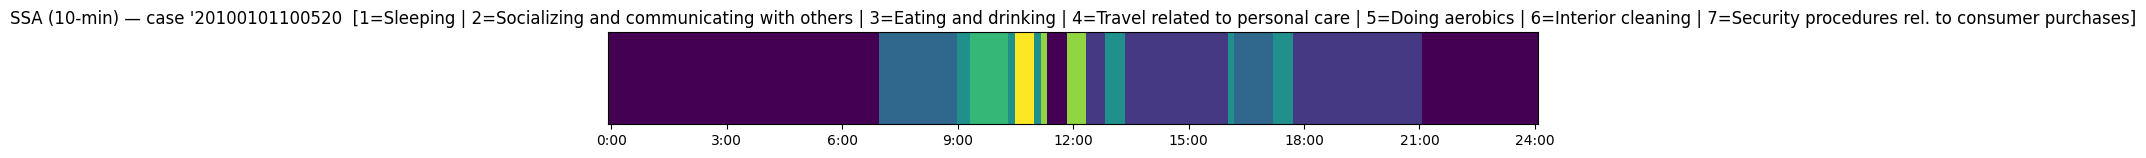

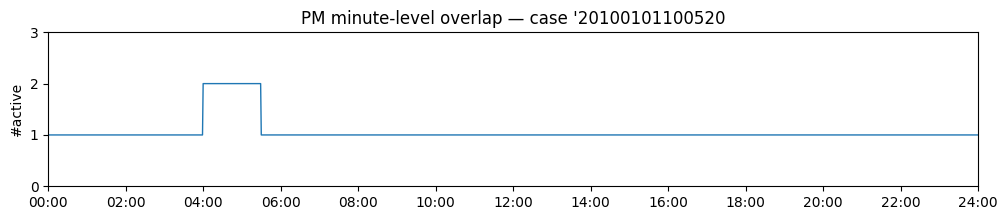

In [7]:
plot_ssa_strip(ssa_states, title=f"SSA (10-min) — case {case_df['case_id'].iloc[0]}")
plot_overlap(counts,     title=f"PM minute-level overlap — case {case_df['case_id'].iloc[0]}")


In [8]:
# Scan all cases to find those with overlap and summarize them
def overlap_summary(g):
    segs = split_cross_midnight(g.sort_values(["start_time","stop_time","event_n"]))
    counts = np.zeros(1440, dtype=np.int16)
    for s,e,_ in segs:
        counts[s:e] += 1
    return pd.Series({
        "max_concurrent": int(counts.max()),
        "overlap_minutes": int((counts >= 2).sum()),
        "active_minutes": int((counts > 0).sum())
    })

cand = (df.groupby("case_id", sort=False)
          .apply(overlap_summary)
          .reset_index()
          .query("overlap_minutes > 0")
          .sort_values(["max_concurrent","overlap_minutes"], ascending=[False, False]))

print("Found cases with overlap:", len(cand))
display(cand.head(10))


Found cases with overlap: 627


C:\Users\hp\AppData\Local\Temp\ipykernel_23024\4148729991.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(overlap_summary)


,case_id,max_concurrent,overlap_minutes,active_minutes
62,'20100112092212,2,630,1440
288,'20100605100746,2,510,1440
150,'20100302101975,2,465,1440
454,'20100908101719,2,420,1440
560,'20101110100536,2,420,1440
43,'20100112091455,2,390,1440
49,'20100112091663,2,390,1440
210,'20100403102004,2,390,1440
242,'20100504100984,2,390,1440
556,'20101109101831,2,390,1440
